# 95-791 Data Mining (Fall 2021) - Final Project, Part 2
### Name: Jamie Lim, Thomas Tam, Tina Feng

# Question 1: 
Given an individual's criminal record, is he/she likely to recidivate* and what are the main features associated with recidivism?

For this task, we pick `Recidivism_Within_3Years` as our target variable and use the rest variables excluding `Recidivism_Arrest_Year1`, `Recidivism_Arrest_Year2`, and `Recidivism_Arrest_Year3` as features.

The question can be answered with classification models and feature importance. Here we will explore six classification models as follows:
1. Logistic Regression
    - Suitable for binary target variable
2. K-Nearest Neighbors
    - Suitable for classification tasks
    - Simple & intuitive
3. Naive Bayes Classifier
    - Suitable for classification tasks
    - Efficient and not biased by outliers
4. Random Forest 
    - Powerful and accurate
5. Boosting (Gradient/ Adaboost)
    - enables a more complex ensemble 
    
*recidivate within 3 years of parole supervision start date

In [1]:
# import needed libraries and packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# read csv file
df_cleaned = pd.read_csv('df_cleaned.csv')
df_cleaned.head()

,Gender,Race,Age_at_Release,Gang_Affiliated,Supervision_Risk_Score_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,...,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Supervision_Level_First_High,Supervision_Level_First_Standard,Prison_Offense_Drug,Prison_Offense_Property,Prison_Offense_Violent/Non-Sex,Prison_Offense_Violent/Sex
0,1.0,0.0,5.0,0.0,2.0,2.0,3.0,3.0,7.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,3.0,0.0,5.0,0.0,1.0,3.0,8.0,6.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,6.0,0.0,6.0,2.0,3.0,1.0,7.0,6.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,4.0,0.0,6.0,0.0,1.0,1.0,9.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,5.0,4.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Comment:** 

Since our target variable is binary, the two classes (recidivised vs not recidivised) are acceptably balanced (~59% vs ~41%). Therefore, we will proceed with the current data points without doing any modification

## 1. Model Selection

In [3]:
# get y 
y = df_cleaned['Recidivism_Within_3years']
y.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: Recidivism_Within_3years, dtype: float64

In [4]:
# get X
X = df_cleaned.drop(['Recidivism_Within_3years','Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3'], axis=1)
X.head()

,Gender,Race,Age_at_Release,Gang_Affiliated,Supervision_Risk_Score_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,...,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Supervision_Level_First_High,Supervision_Level_First_Standard,Prison_Offense_Drug,Prison_Offense_Property,Prison_Offense_Violent/Non-Sex,Prison_Offense_Violent/Sex
0,1.0,0.0,5.0,0.0,2.0,2.0,3.0,3.0,7.0,6.0,...,0.0,0.488562,0.447610,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,3.0,0.0,5.0,0.0,1.0,3.0,8.0,6.0,...,0.0,0.425234,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,6.0,0.0,6.0,2.0,3.0,1.0,7.0,6.0,...,0.0,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,4.0,0.0,6.0,0.0,1.0,1.0,9.0,6.0,...,0.0,1.000000,0.718996,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,5.0,4.0,...,0.0,0.203562,0.929389,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# split into train&test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 1.1 Logistic Regression

In [6]:
# create logit object
logit = LogisticRegression(max_iter=1000)

# train the model
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
# make predictions
pred = logit.predict(X_test)

In [8]:
# plot confusion matrix
cm_logit = confusion_matrix(y_test,pred)
display_cm_logit = ConfusionMatrixDisplay(confusion_matrix=cm_logit, display_labels=['No (0)','Yes (1)'])

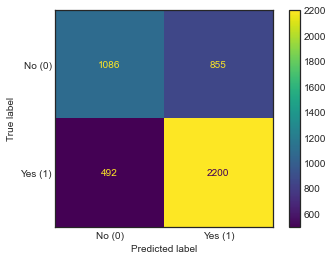

In [9]:
display_cm_logit.plot()

In [10]:
# classification report
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.688     0.560     0.617      1941
         1.0      0.720     0.817     0.766      2692

    accuracy                          0.709      4633
   macro avg      0.704     0.688     0.691      4633
weighted avg      0.707     0.709     0.703      4633



**Comment:** 

Logistic regression model has an accuracy of 0.705 and this model seems to perform better with classifying class 1 (higher precision and recall)

### 1.2 K-Nearest Neighbors

In [11]:
# tuning parameter k
# create holder for cv errors
knn_cverrs = {}
# create KNN model object
knn = KNeighborsClassifier()
# loop over k from 1 to 29
for i in range(1,30):
    knn.set_params(n_neighbors=i)
    # get cv error for each k and store it
    CV_error = np.mean(cross_val_score(knn, X_train, y_train, cv=5))
    knn_cverrs[i] = CV_error
# choose the best k by minimum cv error
k_best = min(knn_cverrs, key=knn_cverrs.get)

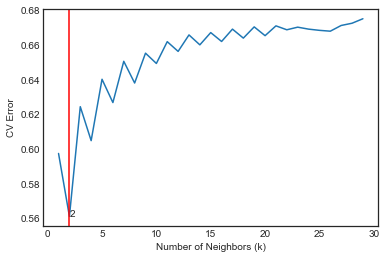

In [12]:
# plot CV error vs Number of neighbors
plt.plot(range(1,30),[val for i,val in knn_cverrs.items()])
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("CV Error")
plt.axvline(x = k_best,color='r')
plt.text(x=k_best,y=min([i for k,i in knn_cverrs.items()]),s=k_best)
plt.show()

In [13]:
# refit the KNN model with best k = 2
knn = KNeighborsClassifier(n_neighbors=k_best).fit(X_train, y_train)
# get predicted target value
y_pred = knn.predict(X_test)

# generate and plot confusion matrix
cm_knn_best = confusion_matrix(y_test,y_pred)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm_knn_best, display_labels=['No (0)','Yes (1)'])

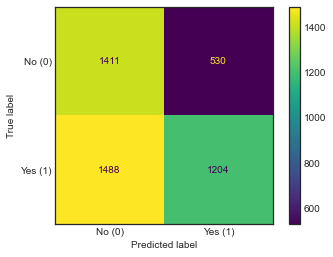

In [14]:
display_cm.plot()

In [15]:
# print classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.487     0.727     0.583      1941
         1.0      0.694     0.447     0.544      2692

    accuracy                          0.564      4633
   macro avg      0.591     0.587     0.564      4633
weighted avg      0.607     0.564     0.560      4633



**Comment:** 

KNN model has an accuracy of 0.564 and this model seems to have an average performance in classifying both class 0 (lower precisino but higher recall) and class 1 (higher precision but lower recall)

### 1.3 Naive Bayes Classifier

In [16]:
# set Naive Bayes classifier
NB = GaussianNB()
# fit the classifier using training data
NB.fit(X_train, y_train)
# predict target using the model fit
NB_pred = NB.predict(X_test)
# generate and plot confusion matrix
cm_NB = confusion_matrix(y_test, NB_pred)
display_cm_NB = ConfusionMatrixDisplay(confusion_matrix = cm_NB, display_labels=['No (0)','Yes (1)'])

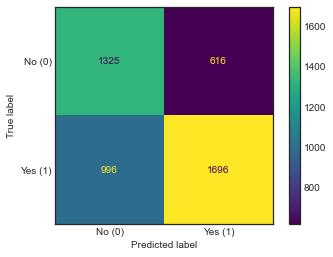

In [17]:
display_cm_NB.plot()                              

In [18]:
# print classification report
print(classification_report(y_test, NB_pred, digits=3))


              precision    recall  f1-score   support

         0.0      0.571     0.683     0.622      1941
         1.0      0.734     0.630     0.678      2692

    accuracy                          0.652      4633
   macro avg      0.652     0.656     0.650      4633
weighted avg      0.665     0.652     0.654      4633



**Comment:** 

Naive Bayes Classifier has an accuracy of 0.605 and this model seems to perform better with classifying class 1 (higher precision, although class 0 has a relatively higher recall)

### 1.4 Random Forest 

In [19]:
# create random forest object
rf = RandomForestClassifier(random_state=0)
# use GridSearchCV to tune hyperparameter for random forest
# Here we include max_features = None for include bagging as one potential model
rf_gs = GridSearchCV(rf,param_grid={'n_estimators':range(500,1001, 100), 'max_features':[None,'sqrt','log2']}) 
rf_gs.fit(X_train, y_train)
# get the best hyperparameters
rf_gs.best_params_

{'max_features': 'log2', 'n_estimators': 600}

In [20]:
# refit the random forest model using the best hyperparameters
rf = RandomForestClassifier(n_estimators = 600, max_features = 'log2', random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
# generate and plot confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
display_cm_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels=['No (0)','Yes (1)'])

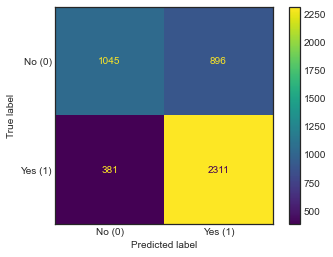

In [21]:
display_cm_rf.plot()                              

In [22]:
# print classification report
print(classification_report(y_test, rf_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.733     0.538     0.621      1941
         1.0      0.721     0.858     0.784      2692

    accuracy                          0.724      4633
   macro avg      0.727     0.698     0.702      4633
weighted avg      0.726     0.724     0.715      4633



**Comment:** 

Random forest model has an accuracy of 0.724 and this model seems to perform better with classifying class 1 (comparable precision and higher recall)

### 1.5 Gradient Boosting

In [23]:
# create gradient boosting classifier object
gb_clf = GradientBoostingClassifier(random_state=0)
# use GridSearchCV to tune hyperparameter for gradient boosting
params = {'n_estimators':[100,500], 'learning_rate':[0.05, 0.1]}
gb_gs = GridSearchCV(gb_clf, param_grid=params)
gb_gs.fit(X_train, y_train)
# get the best parameters
gb_gs.best_params_

{'learning_rate': 0.05, 'n_estimators': 500}

In [24]:
# refit the gradient boosting classifier using best parameters
gb_clf = GradientBoostingClassifier(learning_rate=0.05,n_estimators=500, random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
# generate and plot confusion matrix
cm_gb = confusion_matrix(y_test, gb_pred)
display_cm_gb = ConfusionMatrixDisplay(confusion_matrix = cm_gb, display_labels=['No (0)','Yes (1)'])

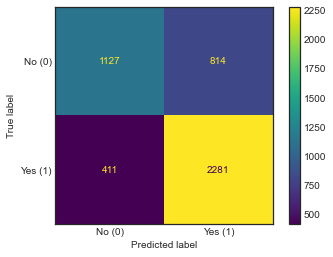

In [25]:
display_cm_gb.plot()                              

In [26]:
# print classification result
print(classification_report(y_test, gb_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.733     0.581     0.648      1941
         1.0      0.737     0.847     0.788      2692

    accuracy                          0.736      4633
   macro avg      0.735     0.714     0.718      4633
weighted avg      0.735     0.736     0.729      4633



**Comment:** 

Gradient boosting model has an accuracy of 0.736 and this model seems to perform better with classifying class 1 (higher precision and recall)

### 1.6 Ada Boost

In [27]:
# create ada boosting classifier object using best parameters
ab_clf = AdaBoostClassifier(random_state=0)
# use GridSearchCV to tune hyperparameter for ada boosting
params = {'n_estimators':[100,500], 'learning_rate':[0.05, 0.1]}
ab_gs = GridSearchCV(ab_clf, param_grid=params)
ab_gs.fit(X_train, y_train)
# get the best parameters
ab_gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [28]:
# refit ada boosting classifier
ab_clf = AdaBoostClassifier(learning_rate=0.1,n_estimators=500, random_state=0)
ab_clf.fit(X_train, y_train)
ab_pred = ab_clf.predict(X_test)
# generate and plot confusion matrix
cm_ab = confusion_matrix(y_test, ab_pred)
display_cm_ab = ConfusionMatrixDisplay(confusion_matrix = cm_ab, display_labels=['No (0)','Yes (1)'])

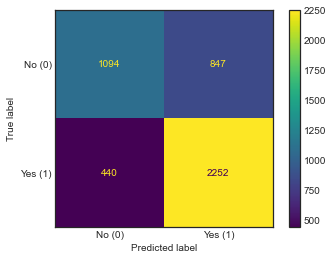

In [29]:
display_cm_ab.plot()

In [30]:
# print classification model
print(classification_report(y_test, ab_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.713     0.564     0.630      1941
         1.0      0.727     0.837     0.778      2692

    accuracy                          0.722      4633
   macro avg      0.720     0.700     0.704      4633
weighted avg      0.721     0.722     0.716      4633



**Comment:** 

Ada boosting model has an accuracy of 0.722 and this model seems to perform better with classifying class 1 (higher precision and recall)

## 2. Model Validation 
-  Using ROC Curve and AUC

In [31]:
# Logit Regression
# get predicted probability of test data
logit_probs = logit.predict_proba(X_test)
# extract the positive columns for each output
logit_auc = roc_auc_score(y_test, logit_probs[:, 1])
# get fpr, tpr, and tresholds for roc curve
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_test, logit_probs[:, 1])

In [32]:
# kNN model
# get predicted probability of test data
knn_probs = knn.predict_proba(X_test)
# extract the positive columns for each output
knn_auc = roc_auc_score(y_test, knn_probs[:, 1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_probs[:, 1])

In [33]:
# naive bayes model
# get predicted probability of test data
nb_probs = NB.predict_proba(X_test)
# extract the positive columns for each output
nb_auc = roc_auc_score(y_test, nb_probs[:, 1])
# get fpr, tpr, and tresholds for roc curve
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_probs[:, 1])

In [34]:
# random forest
# get predicted probability of test data
rf_probs = rf.predict_proba(X_test)
# extract the positive columns for each output
rf_auc = roc_auc_score(y_test, rf_probs[:, 1])
# get fpr, tpr, and tresholds for roc curve
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs[:, 1])

In [35]:
# gradient boost
# get predicted probability of test data
gb_clf_probs = gb_clf.predict_proba(X_test)
# extract the positive columns for each output
gb_auc = roc_auc_score(y_test, gb_clf_probs[:, 1])
# get fpr, tpr, and tresholds for roc curve
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_clf_probs[:, 1])

In [36]:
# Ada boost
# get predicted probability of test data
ab_clf_probs = ab_clf.predict_proba(X_test)
# extract the positive columns for each output
ab_auc = roc_auc_score(y_test, ab_clf_probs[:, 1])
# get fpr, tpr, and tresholds for roc curve
ab_fpr, ab_tpr, ab_thresholds = roc_curve(y_test, ab_clf_probs[:, 1])

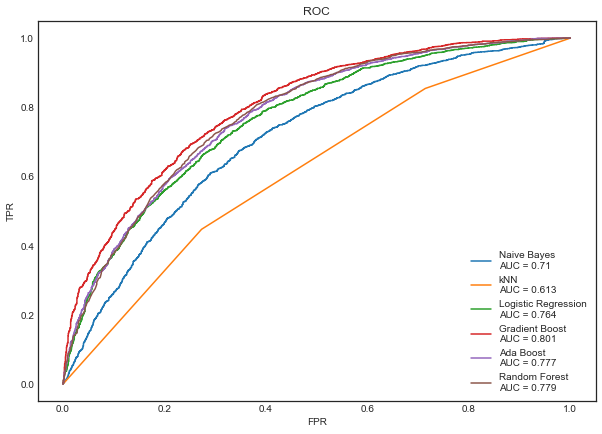

In [37]:
# plot ROC Curve and AUC for all six models
plt.figure(figsize=[10,7])

plt.plot(nb_fpr,nb_tpr,label=f'Naive Bayes\nAUC = {round(nb_auc,3)}')
plt.plot(knn_fpr,knn_tpr,label=f'kNN\nAUC = {round(knn_auc,3)}')
plt.plot(logit_fpr,logit_tpr,label=f'Logistic Regression\nAUC = {round(logit_auc,3)}')
plt.plot(gb_fpr, gb_tpr,label=f'Gradient Boost\nAUC = {round(gb_auc,3)}')
plt.plot(ab_fpr, ab_tpr,label=f'Ada Boost\nAUC = {round(ab_auc,3)}')
plt.plot(rf_fpr, rf_tpr,label=f'Random Forest\nAUC = {round(rf_auc,3)}')


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()
plt.show()

### 2.1 Evaluation of ROC Curve / AUC
- **ROC: Receiver Operating Characteristics**
    - Measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the model’s sensitivity and specificity. Can simultaneously display the two types of errors (**false positive rate** & **true positive rate**) for all possible thresholds.
    - **The true positive rate (TPR) is the sensitivity**: the fraction of recidivised cases within three years that are correctly identified, using a given threshold value. 
    - **The false positive rate (FPR) is 1-specificity**: the fraction of non-recidivised cases that we classify incorrectly as recidivised cases, using that same threshold value.
    - The threshold value decreases along the curve from lower left to upper right. 
        - When threshold decreases, TPR and FPR increase. 
        - When threshold increases, TPR and FPR decrease. 
        
    
- **AUC: Area Under The Curve**
    - Measure the area under the ROC curve
    - Computation of the relationship between false positives and true positives.
    - Ranges from 0 to 1
    - The worst case would be a random classifier with AUC = 0.5 (diagonal)
    - "As a rule of thumb, an AUC above 0.85 means high classification accuracy, one between 0.75 and 0.85 moderate accuracy, and one less than 0.75 low accuracy" (D' Agostino, Rodgers, & Mauck, 2018)
 

- **Ideal Case**
    - An ideal ROC curve will stay closer to the top left corner, so the larger area under the curve (AUC), the better the classifier. 
    
    
- **Model Evaluation**
    - Among the 6 classification models, the Gradient Boosting model yields the highest AUC of 0.801, which is considered to have moderate accuracy, so we pick it as the best model.


## 3. Best Model Performance

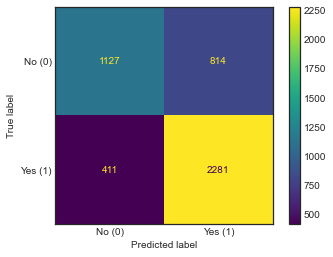

In [38]:
# Get confusion matrix of gradient boosting
display_cm_gb.plot()   

In [39]:
# print classification report
print(classification_report(y_test, gb_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.733     0.581     0.648      1941
         1.0      0.737     0.847     0.788      2692

    accuracy                          0.736      4633
   macro avg      0.735     0.714     0.718      4633
weighted avg      0.735     0.736     0.729      4633



### 3.1 Interpretation of Classification Results from the Best Model
- Since our goal is to use personal information, criminal and supervision history to predict the probability a person will commit new felony/misdemeanor crime within 3 years of parole supervision start date（from the perspective of public safety), we would focus more on **recall related to true positive rate** $Recall = \frac{TP}{TP+FN}$


- In this case, FN is more costly than FP
    - FN: recidivists not classified as recidivists
    - FP: non-recidivists classified as recidivists
    - **FN cases would be a potential threat to public safety if not well addressed. Therefore, we want to increase TP and lower FN**


- Our best model has an accuracy of 73.6% and a recall rate of 84.7%
    - $Accuracy = \frac{TP+TN}{N}$
        - The proportion correctly classified recidivists and non-recidivists by our model on the test data is 73.6%
    - $Recall = \frac{TP}{TP+FN}$ 
        - Among all recidivists, the proportion of correctly classified recidivists by our model on the test data is 84.7%

    
We don't discuss precision here because our main discussion is public safety. We would focus more on precision related to the false positive rate if our goal is to prevent wrongful convictions (future discussion).



## 4. Feature Importance 

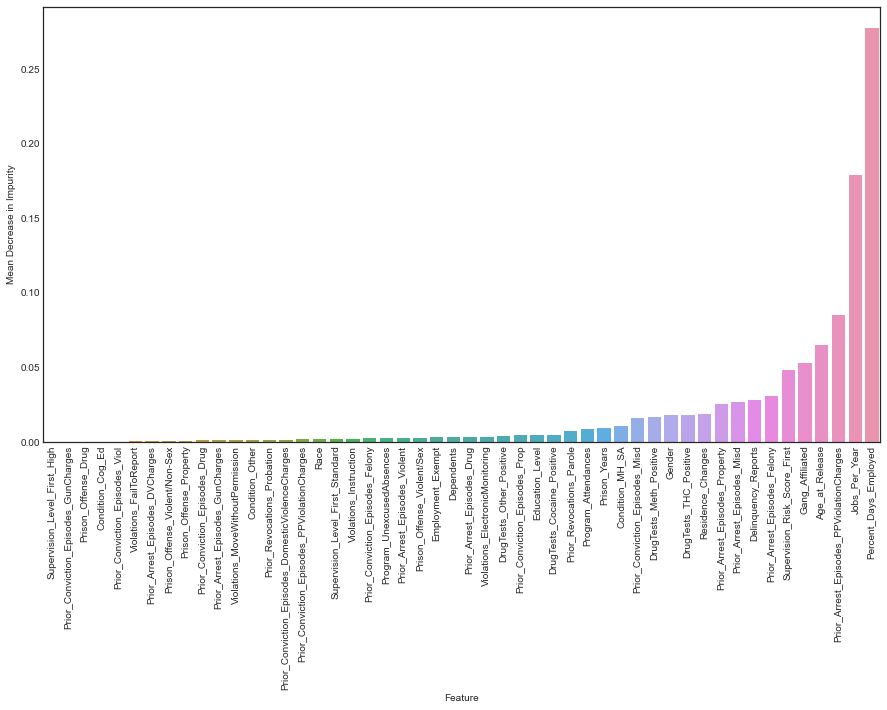

In [40]:
# plot feature importance plot
feature_df = pd.concat([pd.Series(X_train.columns), pd.DataFrame(gb_clf.feature_importances_)], axis=1)
feature_df.columns = ['Feature', 'Mean Decrease in Impurity']
feature_df.sort_values(by = ['Mean Decrease in Impurity'], inplace=True)
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
sns.barplot(x= 'Feature', y= 'Mean Decrease in Impurity', data=feature_df)
plt.show()

## Answer to Q1

To predict a potential recidivism case and determine the main features associated with recidivism, we explored 6 different classification models. Among them, we chose the Gradient Boosting model as our best model as it yielded the highest AUC of 0.801.  

According to our best model, the following TOP 7 important features were associated with recidivism:  
- Percent days employeed 
- Jobs per year
- Prior arrest episodes PPViolationCharges
- Age at released 
- Gang affiliated 
- Supervision risk score first
- Prior arrest episodes felony 


# References
- ISLR - Chapter 4: Classification Methods
- ISLR - Chapter 8: Tree-Based Methods
- In-class Classification Exercise
- Homework 2
- Homework 3
- [Definition of ROC & AUC](https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html)
- [Evaluating AUC](https://www.tc.columbia.edu/elda/blog/content/receiver-operating-characteristic-roc-area-under-the-curve-auc/)